<a href="https://colab.research.google.com/github/aashrithresearch/WoundAI/blob/main/Copy_of_densenet169.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from fastai.vision.all import *
from fastai.callback.fp16 import *
import torch
import os

In [ ]:
from google.colab import files
files.upload()

In [4]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download 'ibrahimfateen/wound-classification'

Dataset URL: https://www.kaggle.com/datasets/ibrahimfateen/wound-classification
License(s): unknown
 90% 81.0M/89.8M [00:01<00:00, 51.0MB/s]
100% 89.8M/89.8M [00:01<00:00, 47.5MB/s]


In [6]:
! unzip /content/wound-classification.zip -d /content

Archive:  /content/wound-classification.zip
  inflating: /content/Wound_dataset copy/Abrasions/abrasions (1).jpg  
  inflating: /content/Wound_dataset copy/Abrasions/abrasions (10).jpg  
  inflating: /content/Wound_dataset copy/Abrasions/abrasions (11).jpg  
  inflating: /content/Wound_dataset copy/Abrasions/abrasions (12).jpg  
  inflating: /content/Wound_dataset copy/Abrasions/abrasions (13).jpg  
  inflating: /content/Wound_dataset copy/Abrasions/abrasions (14).jpg  
  inflating: /content/Wound_dataset copy/Abrasions/abrasions (15).jpg  
  inflating: /content/Wound_dataset copy/Abrasions/abrasions (16).jpg  
  inflating: /content/Wound_dataset copy/Abrasions/abrasions (17).jpg  
  inflating: /content/Wound_dataset copy/Abrasions/abrasions (18).jpg  
  inflating: /content/Wound_dataset copy/Abrasions/abrasions (19).jpg  
  inflating: /content/Wound_dataset copy/Abrasions/abrasions (2).jpg  
  inflating: /content/Wound_dataset copy/Abrasions/abrasions (20).jpg  
  inflating: /content/

In [7]:
fnames = '/content/Wound_dataset copy'

In [8]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y = parent_label,
                   splitter = RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms = Resize(224),
                   batch_tfms = aug_transforms(mult=2))
dls = dblock.dataloaders(fnames, bs=32)

In [9]:
train_ds = dls.train_ds
dls = dblock.dataloaders(fnames)
from collections import Counter
class_counts = Counter([train_ds.items[i].parent.name for i in range(len(train_ds))])

print("Number of samples per class in the training set:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

Number of samples per class in the training set:
Diabetic Wounds: 364
Pressure Wounds: 493
Venous Wounds: 403
Cut: 80
Laseration: 90
Normal: 158
Surgical Wounds: 330
Abrasions: 137
Bruises: 191
Burns: 106


In [10]:
valid_ds = dls.valid_ds
valid_class_counts = Counter([valid_ds.items[i].parent.name for i in range(len(valid_ds))])


print("\nNumber of samples per class in the validation set:")
for cls, count in valid_class_counts.items():
    print(f"{cls}: {count}")


Number of samples per class in the validation set:
Surgical Wounds: 90
Diabetic Wounds: 98
Pressure Wounds: 109
Burns: 28
Venous Wounds: 91
Bruises: 51
Abrasions: 27
Cut: 20
Laseration: 32
Normal: 42


In [11]:
from math import ceil
batch = dls.one_batch()
batch_size = batch[0].shape[0]
ncols = 10
nrows = ceil(batch_size / ncols)

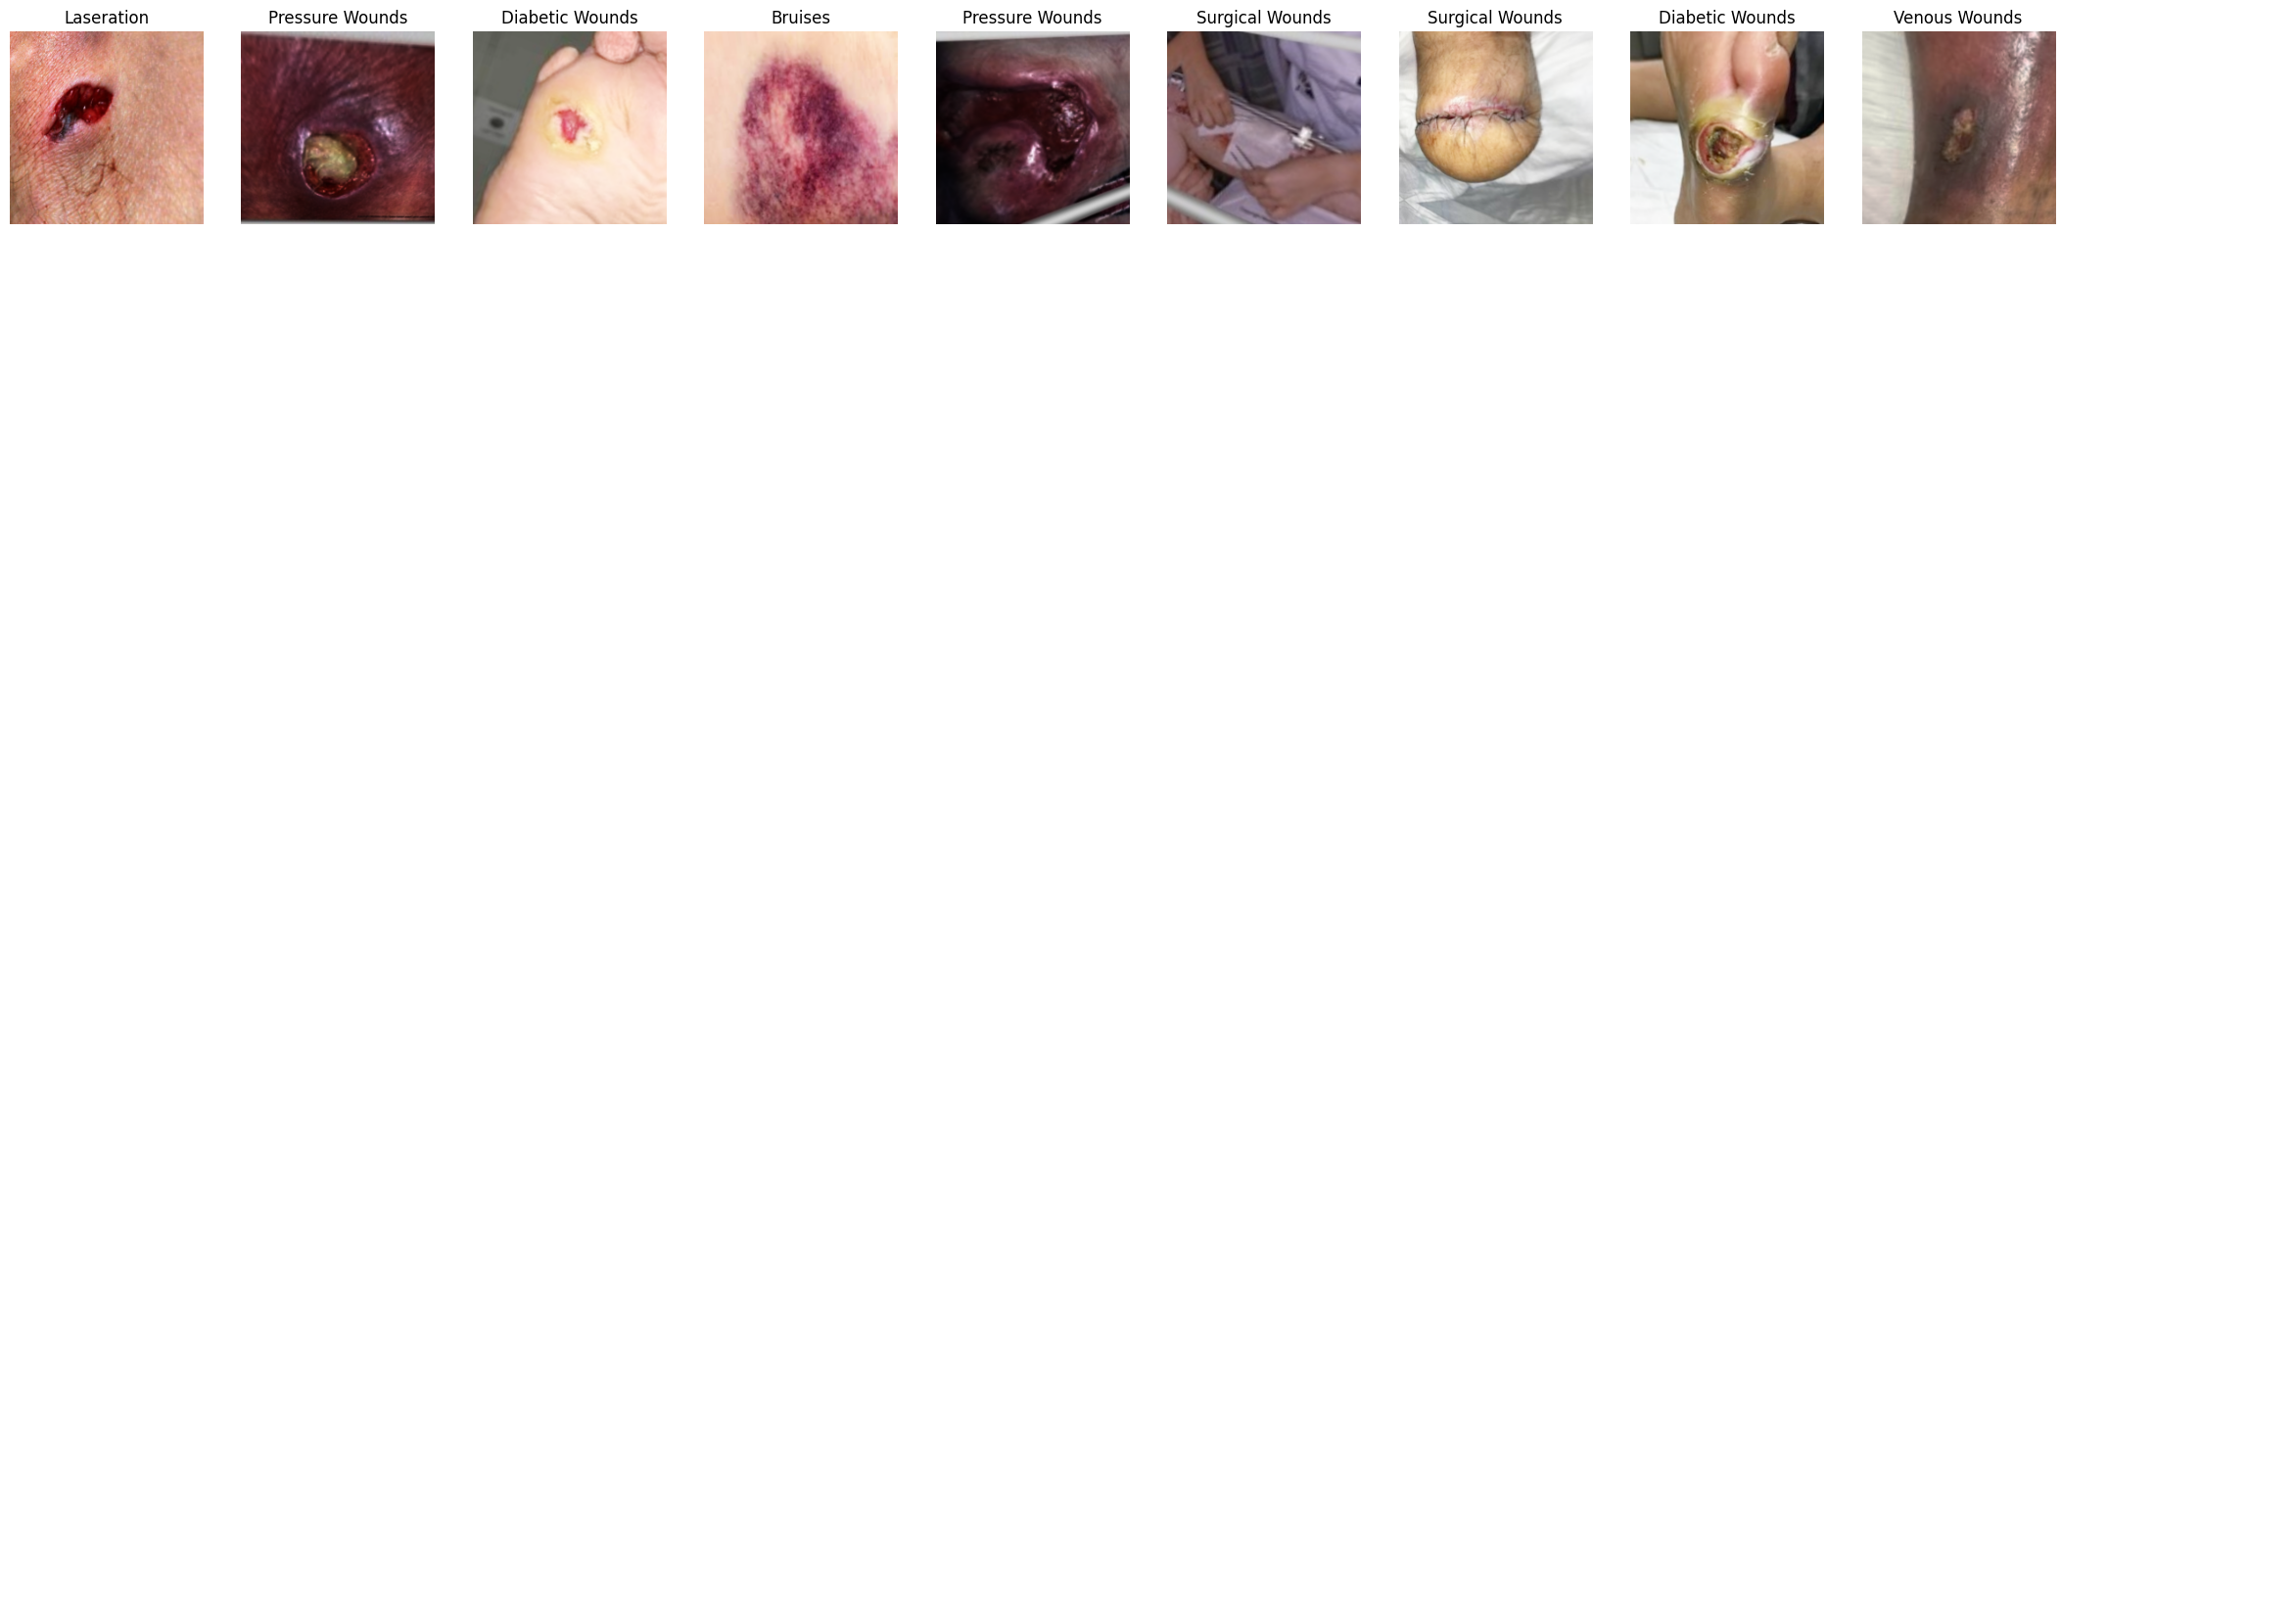

In [12]:
dls.show_batch(nrows=nrows, ncols=10)

In [13]:
metrics =  [
    accuracy,
    Precision(average='macro'),
    Recall(average='macro'),
    F1Score(average='macro'),
    RocAuc(average='macro')
]
learn169 = vision_learner(dls, densenet169, metrics=metrics, loss_func=FocalLoss(), opt_func=Adam).to_fp16()

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 119MB/s]


SuggestedLRs(valley=0.0003981071640737355)

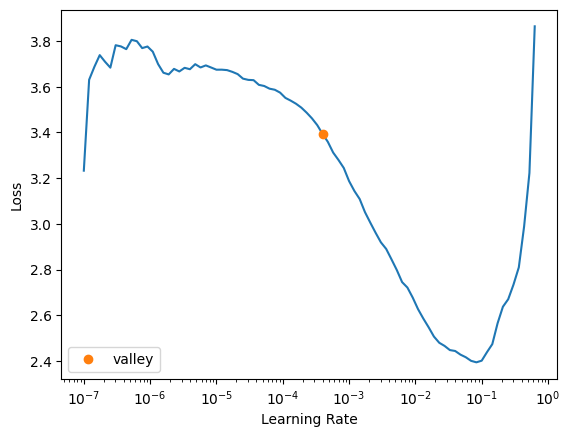

In [14]:
learn169.lr_find()

In [15]:
learn169.fit_one_cycle(20, 1e-4)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,3.566969,2.467561,0.093537,0.113026,0.090748,0.085345,0.528357,00:23
1,3.228306,1.981436,0.181973,0.205859,0.187487,0.173155,0.655344,00:22
2,2.694792,1.293119,0.460884,0.416592,0.454821,0.413965,0.822829,00:21
3,2.215513,0.924742,0.591837,0.572485,0.578818,0.555073,0.903159,00:22
4,1.785214,0.722539,0.683673,0.676587,0.674203,0.660849,0.936607,00:22
5,1.448411,0.609459,0.714286,0.698620,0.719451,0.701757,0.951110,00:23
6,1.224877,0.536520,0.748299,0.752778,0.761941,0.751974,0.962616,00:25
7,1.054146,0.473588,0.785714,0.790884,0.801030,0.790697,0.970805,00:21
8,0.939706,0.406110,0.802721,0.803513,0.811506,0.804538,0.976014,00:23
9,0.849192,0.367410,0.816327,0.820824,0.831417,0.822854,0.979500,00:21


SuggestedLRs(valley=0.00013182566908653826)

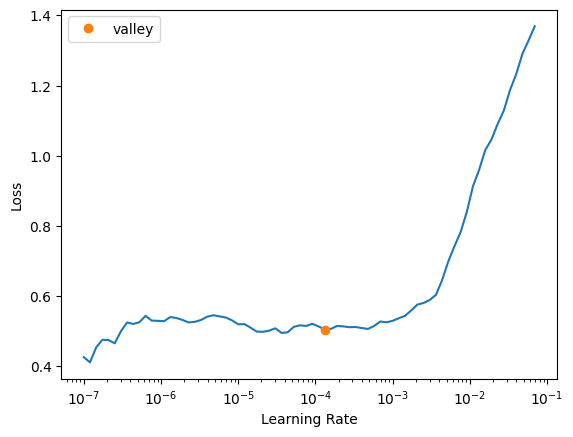

In [16]:
learn169.unfreeze()
learn169.lr_find()

In [17]:
learn169.fit_one_cycle(20, 1e-5)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.570193,0.261938,0.853741,0.856598,0.867189,0.859319,0.987571,00:27
1,0.526298,0.262239,0.857143,0.862691,0.872669,0.865296,0.988008,00:25
2,0.511149,0.258732,0.857143,0.865697,0.867879,0.863298,0.988575,00:24
3,0.496343,0.235789,0.869048,0.870718,0.877341,0.872416,0.989395,00:25
4,0.470696,0.218444,0.869048,0.872866,0.880909,0.875351,0.990598,00:24
5,0.456651,0.202031,0.887755,0.904599,0.899332,0.900153,0.991469,00:26
6,0.462018,0.184973,0.886054,0.891321,0.896197,0.892989,0.992378,00:23
7,0.435081,0.186102,0.887755,0.903961,0.897428,0.899645,0.992499,00:25
8,0.412037,0.178890,0.886054,0.891128,0.893941,0.891660,0.993004,00:25
9,0.392750,0.167629,0.889456,0.900236,0.898098,0.898077,0.993287,00:23


SuggestedLRs(valley=0.00013182566908653826)

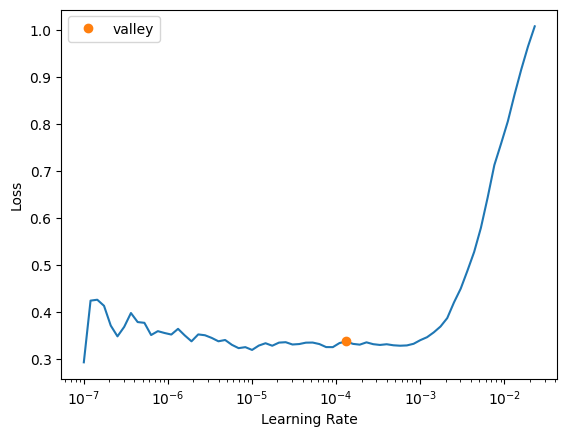

In [18]:
learn169.unfreeze()
learn169.lr_find()

In [19]:
learn169.fit_one_cycle(20, 1e-4)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.344930,0.137096,0.909864,0.924425,0.916047,0.919412,0.995023,00:25
1,0.311855,0.122398,0.920068,0.939305,0.929864,0.933254,0.995684,00:25
2,0.305665,0.130235,0.906463,0.915497,0.921022,0.917124,0.995253,00:27
3,0.283782,0.129109,0.923469,0.922159,0.930724,0.925039,0.995794,00:26
4,0.260710,0.104733,0.925170,0.933144,0.932396,0.931608,0.996947,00:26
5,0.244436,0.103956,0.938776,0.957706,0.949043,0.952980,0.997133,00:24
6,0.224153,0.125601,0.926871,0.929856,0.935635,0.931728,0.997273,00:25
7,0.192460,0.113124,0.937075,0.950579,0.943236,0.945443,0.997998,00:26
8,0.158428,0.083715,0.950680,0.965181,0.962213,0.963009,0.998546,00:24
9,0.145809,0.063730,0.950680,0.958619,0.959753,0.958283,0.999097,00:23


In [20]:
learn169.export('densenet169.pkl')

In [21]:
learn169 = load_learner('densenet169.pkl')